In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/indian-automobile-nse-data/stat_arb_data.csv


In [2]:
prices = pd.read_csv("/kaggle/input/indian-automobile-nse-data/stat_arb_data.csv")

In [3]:
prices['Date'] = pd.to_datetime(prices['Date'])
prices = prices.set_index(prices['Date'])

In [4]:
prices = prices.drop('Date', axis=1)

In [5]:
import itertools

pairs = list(itertools.combinations(prices.columns, 2))
len(pairs)


21

In [6]:
pairs

[('ASHOKLEY.NS', 'BAJAJ-AUTO.NS'),
 ('ASHOKLEY.NS', 'EICHERMOT.NS'),
 ('ASHOKLEY.NS', 'HEROMOTOCO.NS'),
 ('ASHOKLEY.NS', 'M&M.NS'),
 ('ASHOKLEY.NS', 'MARUTI.NS'),
 ('ASHOKLEY.NS', 'TVSMOTOR.NS'),
 ('BAJAJ-AUTO.NS', 'EICHERMOT.NS'),
 ('BAJAJ-AUTO.NS', 'HEROMOTOCO.NS'),
 ('BAJAJ-AUTO.NS', 'M&M.NS'),
 ('BAJAJ-AUTO.NS', 'MARUTI.NS'),
 ('BAJAJ-AUTO.NS', 'TVSMOTOR.NS'),
 ('EICHERMOT.NS', 'HEROMOTOCO.NS'),
 ('EICHERMOT.NS', 'M&M.NS'),
 ('EICHERMOT.NS', 'MARUTI.NS'),
 ('EICHERMOT.NS', 'TVSMOTOR.NS'),
 ('HEROMOTOCO.NS', 'M&M.NS'),
 ('HEROMOTOCO.NS', 'MARUTI.NS'),
 ('HEROMOTOCO.NS', 'TVSMOTOR.NS'),
 ('M&M.NS', 'MARUTI.NS'),
 ('M&M.NS', 'TVSMOTOR.NS'),
 ('MARUTI.NS', 'TVSMOTOR.NS')]

# Trying with one Pair

In [7]:
pair = ['ASHOKLEY.NS', 'BAJAJ-AUTO.NS']

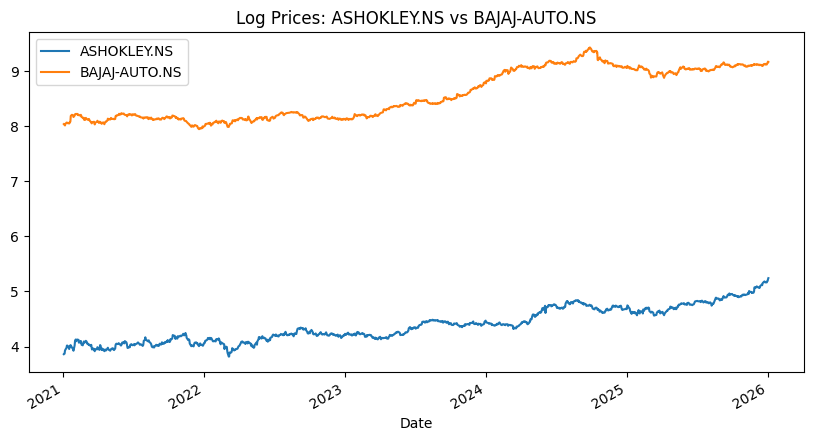

In [8]:
import matplotlib.pyplot as plt

prices[[pair[0], pair[1]]].plot(figsize=(10,5))
plt.title(f'Log Prices: {pair[0]} vs {pair[1]}')
plt.show()

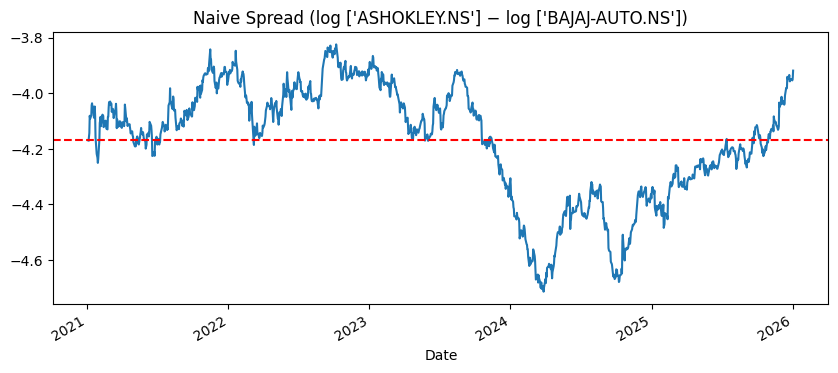

In [9]:
#Using Naive Hedge ratio of 1
spread = prices[pair[0]] - prices[pair[1]]

spread.plot(figsize=(10,4))
plt.title(f'Naive Spread (log {[pair[0]]} − log {[pair[1]]})')
plt.axhline(spread.mean(), color='red', linestyle='--')
plt.show()

## Engle-Granger Test

In [10]:
from statsmodels.tsa.stattools import coint

score, pvalue, crit_vals = coint(
    prices[pair[0]],
    prices[pair[1]]
)

print("Test statistic:", score)
print("p-value:", pvalue)
print("Critical values:", crit_vals)

Test statistic: -1.378490129014092
p-value: 0.8047910757919274
Critical values: [-3.90530832 -3.34106991 -3.04787762]


Yay!! p-value>0.05; not cointegrated

## Extraction of Hedge Ratio (beta)

In [11]:
import statsmodels.api as sm

X = sm.add_constant(prices[pair[1]])
model = sm.OLS(prices[pair[0]], X).fit()

beta = model.params[pair[1]]
alpha = model.params['const']

print("Hedge ratio (beta):", beta)

Hedge ratio (beta): 0.6374571390506213


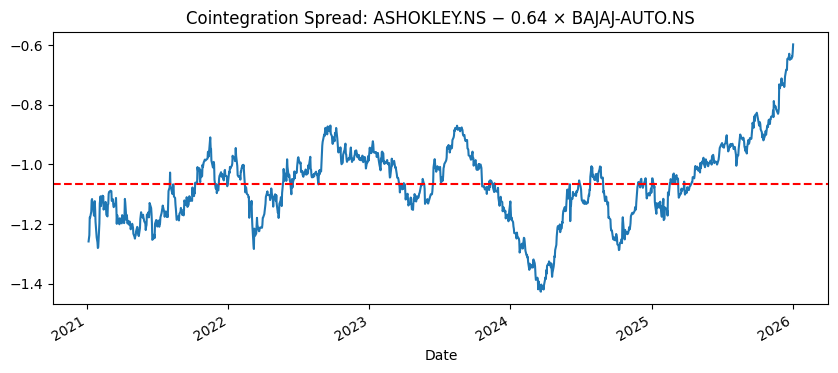

In [12]:
#Constructing proper spread

spread = prices[pair[0]] - beta * prices[pair[1]]

spread.plot(figsize=(10,4))
plt.axhline(spread.mean(), color='red', linestyle='--')
plt.title(f'Cointegration Spread: {pair[0]} − {beta:.2f} × {pair[1]}')
plt.show()

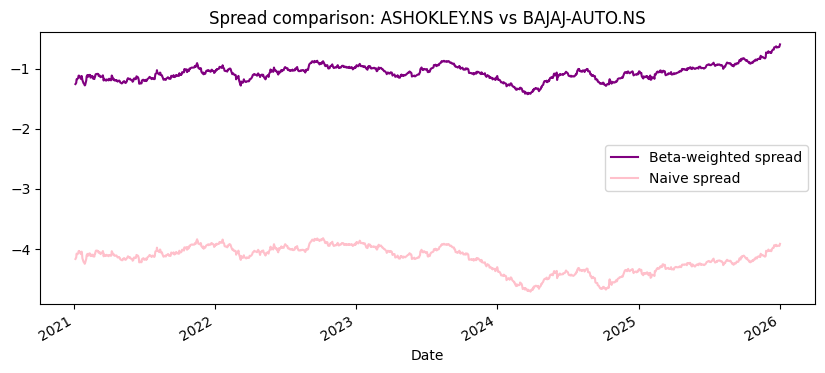

In [13]:
plt.figure(figsize=(10, 4))

control = prices[pair[0]] - prices[pair[1]]
spread = prices[pair[0]] - beta * prices[pair[1]]

spread.plot(color='purple', label='Beta-weighted spread')
control.plot(color='pink', label='Naive spread')

plt.title(f"Spread comparison: {pair[0]} vs {pair[1]}")
plt.legend()
plt.show()

# Constructing Final Spread for cointegrated pairs

In [14]:
# Cointegrated pairs (calculated)
#  asset_1       asset_2    pvalue  
#  1    ASHOKLEY.NS  EICHERMOT.NS  0.002100
#  4    ASHOKLEY.NS     MARUTI.NS  0.004631
#  13  EICHERMOT.NS     MARUTI.NS  0.012956
#  20     MARUTI.NS   TVSMOTOR.NS  0.021914 

In [15]:
def spread_plot(pair):
    X = sm.add_constant(prices[pair[1]])
    model = sm.OLS(prices[pair[0]], X).fit()
    
    beta = model.params[pair[1]]
    spread = prices[pair[0]] - beta * prices[pair[1]]

    spread.plot(figsize=(10,4), label="Spread")
    spread.rolling(60).mean().plot(label="60d mean")
    # spread.rolling(60).std().plot(label="60d std")
    
    plt.legend()
    plt.title(f"Spread diagnostics: {pair[0]} vs {pair[1]}")
    plt.show()
    
    spread_lag = spread.shift(1).dropna()
    spread_ret = spread.diff().dropna()
    
    beta_ar = sm.OLS(spread_ret, spread_lag).fit().params[0]
    
    half_life = -np.log(2) / beta_ar

    zscore = (spread - spread.mean()) / spread.std()
    zscore.plot(figsize=(10,3))
    plt.axhline(2, color='red', linestyle='--')
    plt.axhline(-2, color='red', linestyle='--')
    plt.title("Spread Z-score")
    plt.show()

    return half_life

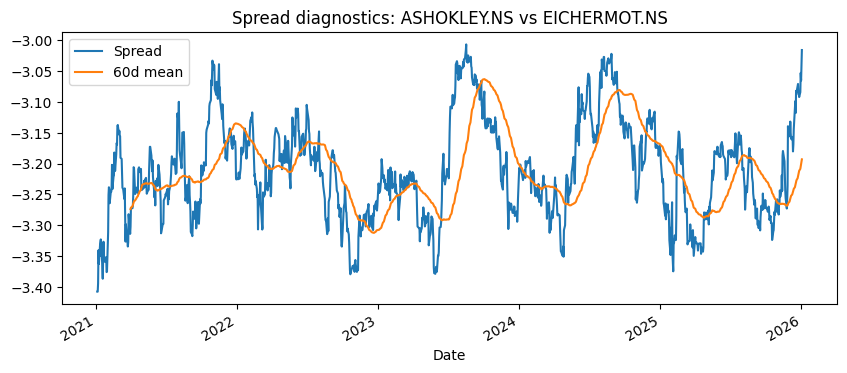

/tmp/ipykernel_55/851343324.py:19: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  beta_ar = sm.OLS(spread_ret, spread_lag).fit().params[0]


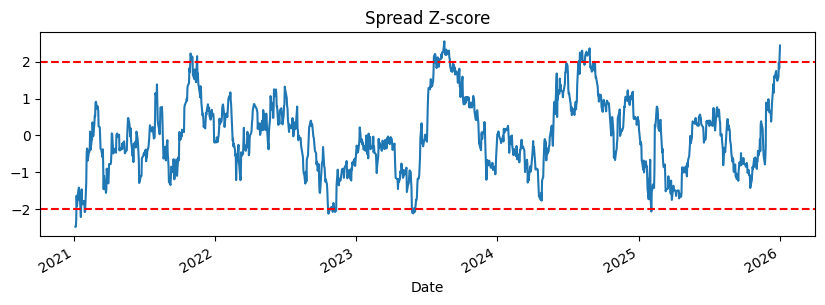

5927.071800954944


In [16]:
half_life = spread_plot(['ASHOKLEY.NS', 'EICHERMOT.NS'])
print(half_life)

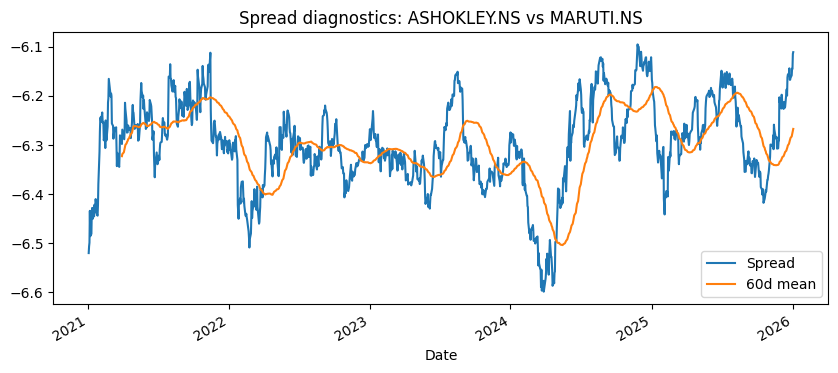

/tmp/ipykernel_55/851343324.py:19: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  beta_ar = sm.OLS(spread_ret, spread_lag).fit().params[0]


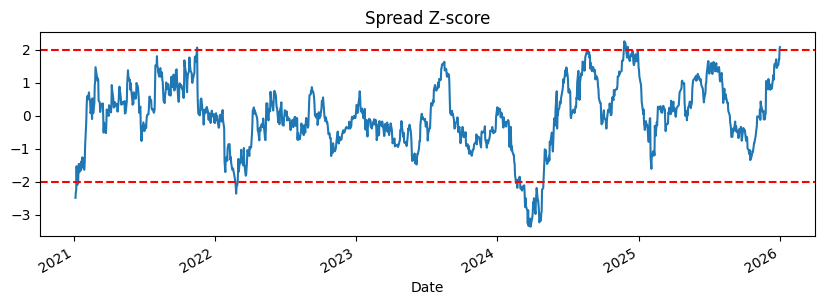

12000.853056434176


In [17]:
half_life = spread_plot(['ASHOKLEY.NS', 'MARUTI.NS'])
print(half_life)

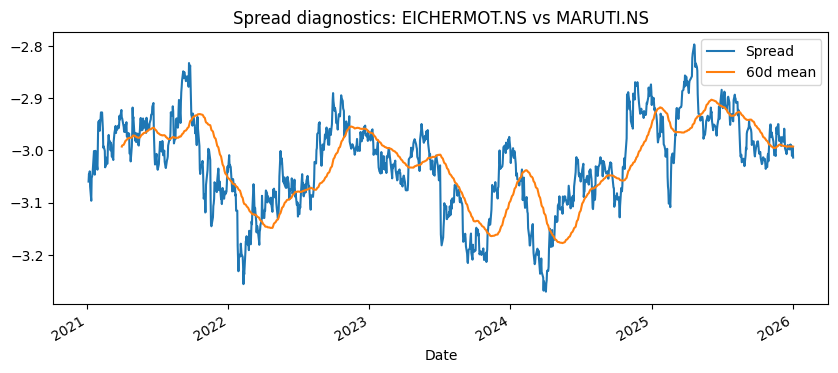

/tmp/ipykernel_55/851343324.py:19: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  beta_ar = sm.OLS(spread_ret, spread_lag).fit().params[0]


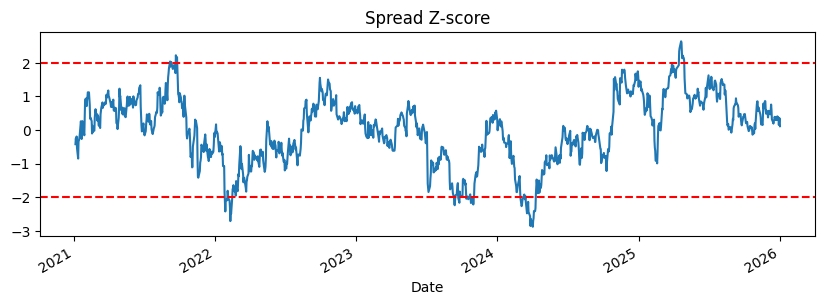

23848.0258825207


In [18]:
half_life = spread_plot(['EICHERMOT.NS', 'MARUTI.NS'])
print(half_life)

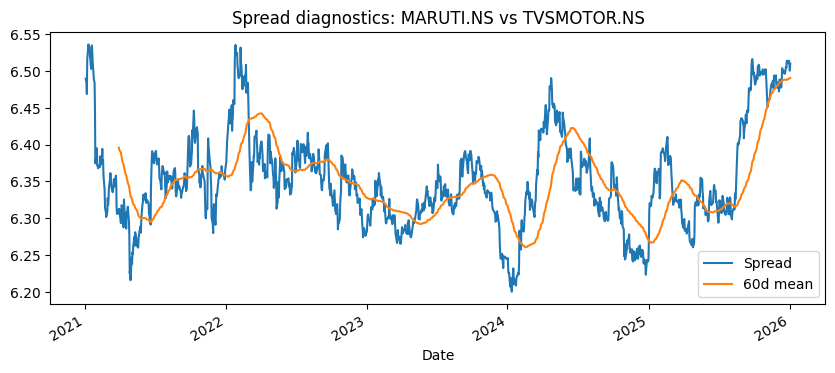

/tmp/ipykernel_55/851343324.py:19: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  beta_ar = sm.OLS(spread_ret, spread_lag).fit().params[0]


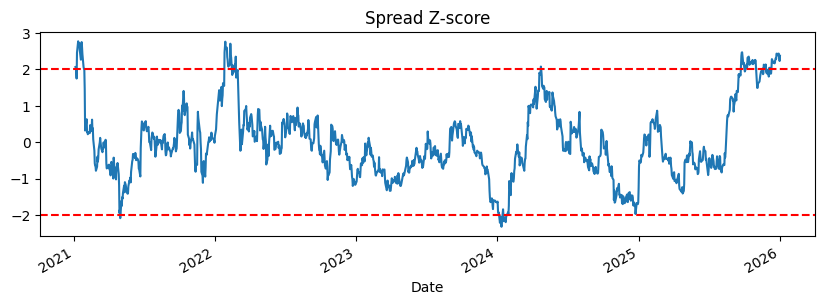

-1406649.886063849


In [19]:
half_life = spread_plot(['MARUTI.NS', 'TVSMOTOR.NS'])
print(half_life)

# Results

Sadly, none of the pairs have a viable enough half life for mean reversion to happen during day trading :(